<a href="https://colab.research.google.com/github/Zahra-Ferdous/Thesis_Human_Action_Recognition_from_Depth_Video/blob/main/depth_cnn_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn
import math
%matplotlib inline
import os
import time

from numba.core.cgutils import if_likely
#from os.path import exists
import os.path 

import cv2
import sklearn
import scipy.io as sio
from numba import jit
from math import factorial, log
from sklearn.neighbors import KDTree
from scipy.signal import periodogram, welch
from astropy.timeseries import LombScargle
from scipy.io import loadmat
import imageio
from skimage import feature, transform, data, io
import tensorflow as tf
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# DEEP LEARNING IMPORTS
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv2D, Activation, Dropout, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix



In [ ]:
dat = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/dmm.mat')

In [ ]:
# ------------------------------------------------ DMM ---------------------------------------------

a = int( str(dat['action'][0][0][0])[1:] )
d = {'front':dat['front'][0][0], 'side':dat['side'][0][0], 'top':dat['top'][0][0], 'action': a}

ser = pd.Series(data = d, index = ['front', 'side', 'top',  'action' ])
l_ser = [ser]

for i in range(1,1165):
  d = { 'front':dat['front'][0][i], 'side':dat['side'][0][i], 'top':dat['top'][0][i],  'action': int( str(dat['action'][0][i][0])[1:] ) }
  #print(int( str(dat['action'][0][i][0])[1:] ))
  ser = pd.Series(data = d, index = ['front', 'side', 'top',  'action' ])
  l_ser.append(ser)


cols = ['front', 'side', 'top', 'action' ]

In [ ]:
df = pd.DataFrame(l_ser, columns=cols)
print(df.shape)

(1165, 4)


In [ ]:
# X = df.drop(['action'],axis = 1)
# Y = df['action']
# df_train, df_test, train_y, test_y = train_test_split(X, Y, random_state = 101, test_size=0.2, stratify = Y)

(932, 4)
(233, 4)


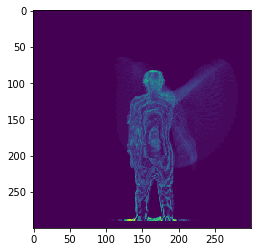

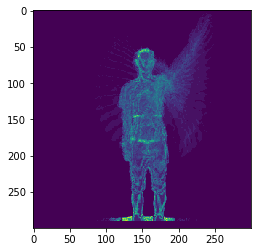

(300, 300)


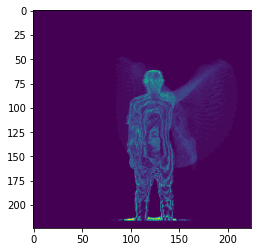

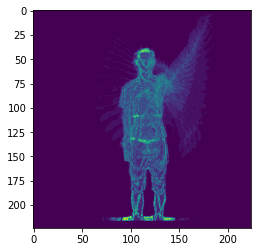

In [ ]:
df_train = df.sample(frac=0.8, random_state=42)
df_test = df.loc[~df.index.isin(df_train.index)]

print(df_train.shape)
print(df_test.shape)
#print(df.head())
df_train_front = np.array(df_train['front'].iloc[0][70:370,100:400])
df_test_front = np.array(df_test['front'].iloc[0][70:370,100:400])

plt.imshow(df_train_front, interpolation='nearest')
plt.show()
plt.imshow(df_test_front, interpolation='nearest')
plt.show()

print(df_test_front.shape)

df_train_front = cv2.resize(df_train_front, dsize=(224,224))
df_test_front = cv2.resize(df_test_front, dsize=(224,224))

plt.imshow(df_train_front, interpolation='nearest')
plt.show()
plt.imshow(df_test_front, interpolation='nearest')
plt.show()

df_train_front1 = np.array([df_train_front])
df_test_front1 = np.array([df_test_front])

In [ ]:
# --------------------------------------- dmm front train --------------------------------------

siz = df_train.shape[0]
for i in range(1,siz):
  df_train_front2 = np.array(df_train['front'].iloc[i][70:370,100:400])
  df_train_front2 = cv2.resize(df_train_front2, dsize=(224,224))
  df_train_front2 = np.array([df_train_front2])
  df_train_front1 = np.concatenate((df_train_front1, df_train_front2), axis=0)
 

print(df_train_front1.shape)

(932, 224, 224)


In [ ]:
# --------------------------------------- dmm front test --------------------------------------

siz = df_test.shape[0]
for i in range(1,siz):
  df_test_front2 = np.array(df_test['front'].iloc[i][70:370,100:400])
  df_test_front2 = cv2.resize(df_test_front2, dsize=(224,224))
  df_test_front2 = np.array([df_test_front2])
  df_test_front1 = np.concatenate((df_test_front1, df_test_front2), axis=0)
  #print(df_test_front1.shape)
print(df_test_front1.shape)

(233, 224, 224)


In [ ]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,annot_kws={"size": 12},fmt='g', cbar=False, cmap="viridis")
    plt.show()


def one_hot_encoder(df_name, df_column_name, suffix=''):
    temp = pd.get_dummies(df_name[df_column_name]) #get dummies is used to create dummy columns
    df_name = df_name.join(temp, lsuffix=suffix) #join the newly created dummy columns to original dataframe
    df_name = df_name.drop(df_column_name, axis=1) #drop the old column used to create dummy columnss
    return df_name

In [ ]:
# -------------------------------- train dataset ----------------------------

train_images_y = df_train[['action']]-1
train_images_y.head()

#do one hot encoding with the earlier created function
train_images_y_encoded = one_hot_encoder(train_images_y, 'action', 'lab')
print(train_images_y_encoded.head())

#get the labels as an array
train_images_y_encoded = train_images_y_encoded.values

train_images_x = df_train_front1
# train_images_array = train_images_x.values
train_x = train_images_x.reshape(train_images_x.shape[0], 224,224 , 1)
train_x_scaled = train_x/255
print(train_x_scaled.shape)

      0   1   2   3   4   5   6   7   8   9   ...  12  13  14  15  16  17  18  \
1116   0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   0   0   0   
107    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
543    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   1   0   0   0   
900    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   
723    0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   0   0   0   

      19  20  21  
1116   0   0   0  
107    1   0   0  
543    0   0   0  
900    0   0   0  
723    0   1   0  

[5 rows x 22 columns]
(932, 224, 224, 1)


In [ ]:
# -------------------------------- test dataset ----------------------------

test_images_y = df_test[['action']] - 1
#do one hot encoding with the earlier created function
test_images_y_encoded = one_hot_encoder(test_images_y, 'action', 'lab')
print(test_images_y_encoded.head())

#get the labels as an array
test_images_y_encoded = test_images_y_encoded.values

test_images_x = df_test_front1
print(test_images_x.shape)
# train_images_array = train_images_x.values
test_x = test_images_x.reshape(test_images_x.shape[0], 224,224, 1)
test_x_scaled = test_x/255
print(test_x_scaled.shape)

    0   1   2   3   4   5   6   7   8   9   ...  12  13  14  15  16  17  18  \
1    0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   0   0   0   
13   0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   0   0   0   
14   0   0   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   0   
20   0   0   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   0   
21   0   0   0   0   0   1   0   0   0   0  ...   0   0   0   0   0   0   0   

    19  20  21  
1    0   0   0  
13   0   0   0  
14   0   0   0  
20   0   0   0  
21   0   0   0  

[5 rows x 22 columns]
(233, 224, 224)
(233, 224, 224, 1)


In [ ]:
sio.savemat('/content/drive/MyDrive/Colab Notebooks/predictions/dmm_front_train_test_224x224.mat',{'train_x': train_images_x, 'test_x': test_images_x, 'train_y':train_images_y_encoded, 'test_y': test_images_y_encoded })

In [ ]:
daf = sio.loadmat('/content/drive/MyDrive/Colab Notebooks/predictions/dmm_front_train_test_224x224.mat')
print(daf.keys())

dict_keys(['__header__', '__version__', '__globals__', 'train_x', 'test_x', 'train_y', 'test_y'])


In [ ]:
print(daf['train_y'])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [ ]:
train_images_x = daf['train_x']
train_x = train_images_x.reshape(train_images_x.shape[0], 224,224, 1)
train_x_scaled = train_x/255
train_images_y_encoded = daf['train_y']



test_images_x = daf['test_x']
test_x = test_images_x.reshape(test_images_x.shape[0], 224,224, 1)
test_x_scaled = test_x/255
test_images_y_encoded = daf['test_y']


In [ ]:
# train_x, test_x, train_y, test_y = train_test_split(train_x_scaled, train_images_y_encoded, random_state = 101, 
                                                  #  test_size=0.25,stratify = train_images_y_encoded)

In [ ]:
def cnn_model(size, num_cnn_layers):
    NUM_FILTERS = 32
    KERNEL = (3, 3)
    #MIN_NEURONS = 20
    MAX_NEURONS = 200
    
    model = Sequential()
    
    for i in range(1, num_cnn_layers+1):
        if i == 1:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, input_shape=size, activation='relu', padding='same'))
            model.add(MaxPooling2D(pool_size=(2,2)))
        else:
            model.add(Conv2D(NUM_FILTERS*i, KERNEL, activation='relu', padding='same'))



    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(int(MAX_NEURONS), activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(int(MAX_NEURONS/2), activation='relu'))
    model.add(Dense(22, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #print(model.summary())
    
    return model

In [ ]:
IMAGE_SIZE = (224,224,1)

In [ ]:
model = cnn_model(IMAGE_SIZE , 2)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 200)               4

In [ ]:
#set early stopping criteria
pat = 10 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
model_checkpoint = ModelCheckpoint('dmm_cnn_1.h5', verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS=10, BATCH_SIZE=128):
    model = None
    model = cnn_model(IMAGE_SIZE, 2)
    results = model.fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, model_checkpoint], 
              verbose=1, validation_split=0.1)  
    print("Val Score: ", model.evaluate(val_x, val_y))
    return results

In [ ]:
n_folds=3
epochs=10
batch_size=128

#save the model history in a list after fitting so that we can plot later
model_history = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(train_x_scaled, train_images_y_encoded, test_size=0.1, 
                                               random_state = 42 , stratify = train_images_y_encoded )
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")


  #np.random.randint(1,1000, 1)[0]

Training on Fold:  1
Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 12.0705 - accuracy: 0.0769
Epoch 1: val_loss improved from inf to 3.02749, saving model to dmm_cnn_1.h5
6/6 [==============================] - 59s 9s/step - loss: 12.0705 - accuracy: 0.0769 - val_loss: 3.0275 - val_accuracy: 0.1786
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 3.1278 - accuracy: 0.1366
Epoch 2: val_loss improved from 3.02749 to 2.85279, saving model to dmm_cnn_1.h5
6/6 [==============================] - 53s 9s/step - loss: 3.1278 - accuracy: 0.1366 - val_loss: 2.8528 - val_accuracy: 0.2262
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 2.8789 - accuracy: 0.2109
Epoch 3: val_loss improved from 2.85279 to 2.84168, saving model to dmm_cnn_1.h5
6/6 [==============================] - 57s 10s/step - loss: 2.8789 - accuracy: 0.2109 - val_loss: 2.8417 - val_accuracy: 0.2381
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 2.7323 - accur

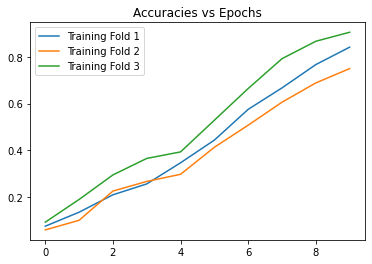

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()


In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()


In [ ]:
#Load the model that was saved by ModelCheckpoint
model = load_model('dmm_cnn_1.h5')

In [ ]:
model.evaluate(val_x, val_y)

3/3 [==============================] - 2s 530ms/step - loss: 0.5750 - accuracy: 0.8191


[0.5749723315238953, 0.8191489577293396]

In [ ]:
model.evaluate(test_x_scaled, test_images_y_encoded)

8/8 [==============================] - 4s 517ms/step - loss: 0.8121 - accuracy: 0.8069


[0.812087893486023, 0.8068669438362122]

In [ ]:
#function for converting predictions to labels
def prep_submissions(preds_array, file_name='abc.csv'):
    preds_df = pd.DataFrame(preds_array)
    predicted_labels = preds_df.idxmax(axis=1) #convert back one hot encoding to categorical variabless
    #return predicted_labels
    
    ### prepare submissions in case you need to submit
    #submission = pd.read_csv("test.csv")
    #submission['label'] = predicted_labels
    predicted_labels.to_csv(file_name, index=False)
    print(pd.read_csv(file_name).head())
    

In [ ]:
test_preds = model.predict(test_x_scaled)
test_preds_labels = prep_submissions(test_preds)

8/8 [==============================] - 4s 503ms/step
    0
0  20
1   6
2   5
3   5
4   5


In [ ]:
prep_submissions(test_preds, '/content/drive/MyDrive/Colab Notebooks/predictions/front_dmm.csv')

    0
0  20
1   6
2   5
3   5
4   5


In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/predictions/dmm_3foldcv_10dec_7_44_pm_test_acc_80_test_loss_81')

In [ ]:
model.save('dmm_3foldcv_10dec_7_44_pm_test_acc_80_test_loss_81')

In [ ]:
print(classification_report(test_x_scaled, test_preds))

ValueError: ignored

In [ ]:
draw_confusion_matrix(test_x_scaled, test_preds_labels)

ValueError: ignored